# 1.30c: Fimbulwinter Timeline Analysis

**Purpose:** Determine the EXACT timestep when motion ceases.

## Question

Is Thimble 6's late-training freeze:
1. **Heat death Fimbulwinter:** Complete cessation of motion at some t << 6000, followed by absolute stillness
2. **Quantum jitter:** Persistent low-amplitude motion that never fully stops

## Method

Vectorized analysis of all 6000 timesteps:
- **Global freeze detection:** Did ANY token move at timestep t?
- **Last motion timesteps:** When did thermal/lattice/any motion last occur?
- **Motion statistics:** Mean displacement, max displacement, fraction moving
- **Regime transitions:** Exact boundaries between thermal → lattice → frozen

If we find permanent freeze starting at t << 6000 with mean displacement = 0.0, that's definitive proof.

## Parameters

In [1]:
# Data path
DATA_PATH = "../tensors/Thimble/thimble_6.h5"

# Classification thresholds
DIAGONAL_FACTOR = 8  # sqrt(64) for hypercube diagonal

# Plot settings
DPI = 200
FIGSIZE = (14, 6)

print("✓ Parameters set")

✓ Parameters set


## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import h5py
from pathlib import Path

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data (Vectorized - Load All Dead Tokens)

In [4]:
print(f"Loading dead token trajectories from {DATA_PATH}...\n")

with h5py.File(DATA_PATH, 'r') as f:
    # Load metadata
    n_steps = f.attrs['num_steps']
    vocab_size = f.attrs['vocab_size']
    hidden_dim = f.attrs['hidden_dim']
    
    # Load token masks
    dead_mask = torch.from_numpy(f['dead_mask'][:]).bool()
    n_dead = dead_mask.sum().item()
    
    # Load ALL dead token trajectories (vectorized)
    print(f"Loading W[:, dead_mask, :] ... ({n_steps+1} timesteps × {n_dead} tokens × {hidden_dim} dims)")
    W_dead_np = f['W'][:, dead_mask, :]  # (6001, 3699, 64) - HDF5 lazy array
    W_dead_bf16 = torch.from_numpy(W_dead_np[:]).to(torch.bfloat16)  # Load to memory
    W_dead = W_dead_bf16.float()  # Convert to float32 for arithmetic

memory_gb = W_dead_bf16.numel() * 2 / 1e9  # bfloat16 = 2 bytes

print(f"\nLoaded shape: {tuple(W_dead.shape)}")
print(f"Memory: {memory_gb:.2f} GB (bfloat16)")
print(f"\n✓ Data loaded (vectorized)")

Loading dead token trajectories from ../tensors/Thimble/thimble_6.h5...

Loading W[:, dead_mask, :] ... (6001 timesteps × 3699 tokens × 64 dims)

Loaded shape: (6001, 3699, 64)
Memory: 2.84 GB (bfloat16)

✓ Data loaded (vectorized)


## Compute ULP Matrices (Vectorized)

In [5]:
print("Computing ULP for all timesteps (vectorized)...\n")

def compute_ulp_matrix(W_bf16):
    """
    Compute ULP for each element using nextafter.
    
    Args:
        W_bf16: Tensor in bfloat16 format (any shape)
    
    Returns:
        ULP matrix (same shape) in float32
    """
    inf_tensor = torch.tensor(float('inf'), dtype=torch.bfloat16, device=W_bf16.device)
    next_up = torch.nextafter(W_bf16, inf_tensor)
    ulp = (next_up - W_bf16).abs().float()
    return ulp

# Compute ULP for all timesteps except last (we need t and t+1 for displacement)
ulp_all = compute_ulp_matrix(W_dead_bf16[:-1])  # (6000, 3699, 64)
mean_ulp_per_token = ulp_all.mean(dim=2)  # (6000, 3699)

print(f"ULP matrix shape: {tuple(ulp_all.shape)}")
print(f"Mean ULP per token: {tuple(mean_ulp_per_token.shape)}")
print(f"\n✓ ULP computation complete")

Computing ULP for all timesteps (vectorized)...

ULP matrix shape: (6000, 3699, 64)
Mean ULP per token: (6000, 3699)

✓ ULP computation complete


## Compute Displacements (Vectorized)

In [6]:
print("Computing displacements (vectorized)...\n")

# Displacement: W[t+1] - W[t] for all timesteps
dW = W_dead[1:] - W_dead[:-1]  # (6000, 3699, 64)
displacement_norms = torch.norm(dW, dim=2)  # (6000, 3699)

print(f"Displacement shape: {tuple(dW.shape)}")
print(f"Displacement norms: {tuple(displacement_norms.shape)}")
print(f"\n✓ Displacement computation complete")

Computing displacements (vectorized)...

Displacement shape: (6000, 3699, 64)
Displacement norms: (6000, 3699)

✓ Displacement computation complete


## Classify Motion Regimes (Vectorized)

In [7]:
print("Classifying motion regimes (vectorized)...\n")

# Thresholds
lattice_threshold = DIAGONAL_FACTOR * mean_ulp_per_token  # (6000, 3699)

# Classify each (timestep, token) pair
frozen = (displacement_norms == 0)  # (6000, 3699)
lattice = (displacement_norms > 0) & (displacement_norms <= lattice_threshold)
thermal = (displacement_norms > lattice_threshold)

# Per-timestep fractions
fraction_frozen = frozen.float().mean(dim=1)  # (6000,)
fraction_lattice = lattice.float().mean(dim=1)
fraction_thermal = thermal.float().mean(dim=1)

# Per-timestep global freeze (ALL tokens frozen)
global_freeze = frozen.all(dim=1)  # (6000,) boolean

# Per-timestep motion detection (ANY token moved)
any_motion = (displacement_norms > 0).any(dim=1)  # (6000,) boolean
any_lattice = lattice.any(dim=1)
any_thermal = thermal.any(dim=1)

print(f"Fraction frozen: {tuple(fraction_frozen.shape)}")
print(f"Global freeze (all frozen): {global_freeze.sum().item()} / {len(global_freeze)} timesteps")
print(f"Any motion: {any_motion.sum().item()} / {len(any_motion)} timesteps")
print(f"\n✓ Classification complete")

Classifying motion regimes (vectorized)...

Fraction frozen: (6000,)
Global freeze (all frozen): 3671 / 6000 timesteps
Any motion: 2329 / 6000 timesteps

✓ Classification complete


## Find Last Motion Timesteps

In [8]:
print("="*80)
print("LAST MOTION TIMESTEPS")
print("="*80 + "\n")

# Find last occurrence of each motion type
thermal_steps = any_thermal.nonzero(as_tuple=True)[0]
lattice_steps = any_lattice.nonzero(as_tuple=True)[0]
motion_steps = any_motion.nonzero(as_tuple=True)[0]

if len(thermal_steps) > 0:
    last_thermal = thermal_steps[-1].item()
    print(f"Last thermal motion (d > 8×ULP):  t={last_thermal}")
else:
    last_thermal = None
    print(f"Last thermal motion (d > 8×ULP):  NONE (never occurred)")

if len(lattice_steps) > 0:
    last_lattice = lattice_steps[-1].item()
    print(f"Last lattice hop (0 < d ≤ 8×ULP): t={last_lattice}")
else:
    last_lattice = None
    print(f"Last lattice hop (0 < d ≤ 8×ULP): NONE (never occurred)")

if len(motion_steps) > 0:
    last_motion = motion_steps[-1].item()
    print(f"Last ANY motion:                  t={last_motion}")
    print(f"\nPermanent freeze begins:          t={last_motion + 1}")
    freeze_duration = len(global_freeze) - (last_motion + 1)
    print(f"Duration of permanent freeze:     {freeze_duration} steps (t={last_motion+1} → t={len(global_freeze)})")
    print(f"Fraction of experiment frozen:    {100*freeze_duration/len(global_freeze):.1f}%")
else:
    last_motion = None
    print(f"Last ANY motion:                  NONE (system never moved!)")

print("\n" + "="*80 + "\n")

LAST MOTION TIMESTEPS

Last thermal motion (d > 8×ULP):  t=91
Last lattice hop (0 < d ≤ 8×ULP): t=3291
Last ANY motion:                  t=3291

Permanent freeze begins:          t=3292
Duration of permanent freeze:     2708 steps (t=3292 → t=6000)
Fraction of experiment frozen:    45.1%




## Motion Statistics Over Time

In [9]:
print("Computing motion statistics...\n")

# Mean displacement (including zeros)
mean_displacement_all = displacement_norms.mean(dim=1)  # (6000,)

# Mean displacement among movers only
mean_displacement_movers = torch.zeros(len(displacement_norms))
for t in range(len(displacement_norms)):
    moving = displacement_norms[t] > 0
    if moving.any():
        mean_displacement_movers[t] = displacement_norms[t][moving].mean()
    else:
        mean_displacement_movers[t] = 0.0

# Max displacement (worst-case single token)
max_displacement = displacement_norms.max(dim=1)[0]  # (6000,)

# Mean ULP
mean_ulp_all = mean_ulp_per_token.mean(dim=1)  # (6000,)

print(f"Mean displacement (all tokens): {tuple(mean_displacement_all.shape)}")
print(f"Mean displacement (movers):     {tuple(mean_displacement_movers.shape)}")
print(f"Max displacement:               {tuple(max_displacement.shape)}")
print(f"Mean ULP:                       {tuple(mean_ulp_all.shape)}")
print(f"\n✓ Statistics computed")

Computing motion statistics...

Mean displacement (all tokens): (6000,)
Mean displacement (movers):     (6000,)
Max displacement:               (6000,)
Mean ULP:                       (6000,)

✓ Statistics computed


## Check for Exact Zero

In [10]:
print("="*80)
print("EXACT ZERO MOTION ANALYSIS")
print("="*80 + "\n")

# Find timesteps with EXACTLY zero mean displacement
exact_zero = (mean_displacement_all == 0.0)
n_exact_zero = exact_zero.sum().item()

print(f"Timesteps with mean displacement = 0.0 exactly: {n_exact_zero} / {len(mean_displacement_all)}")

if n_exact_zero > 0:
    zero_steps = exact_zero.nonzero(as_tuple=True)[0]
    first_zero = zero_steps[0].item()
    
    # Check if zeros are contiguous at the end
    if zero_steps[-1].item() == len(mean_displacement_all) - 1:
        # Find longest contiguous run ending at t=5999
        run_start = first_zero
        for t in range(len(mean_displacement_all) - 1, -1, -1):
            if mean_displacement_all[t] == 0.0:
                run_start = t
            else:
                break
        
        run_length = len(mean_displacement_all) - run_start
        print(f"\n✓ HEAT DEATH FIMBULWINTER DETECTED")
        print(f"  Final zero run: t={run_start} → t={len(mean_displacement_all)-1}")
        print(f"  Duration: {run_length} consecutive steps of EXACT zero motion")
        print(f"  Fraction: {100*run_length/len(mean_displacement_all):.1f}% of experiment")
    else:
        print(f"\n  First exact zero at t={first_zero}")
        print(f"  But zeros are not contiguous through end of experiment.")
else:
    print(f"\n  No timesteps with exact zero displacement.")
    print(f"  System shows persistent low-amplitude quantum jitter.")

# Show minimum non-zero displacement
nonzero_displacements = mean_displacement_all[mean_displacement_all > 0]
if len(nonzero_displacements) > 0:
    min_nonzero = nonzero_displacements.min().item()
    print(f"\n  Minimum non-zero displacement: {min_nonzero:.2e}")

print("\n" + "="*80 + "\n")

EXACT ZERO MOTION ANALYSIS

Timesteps with mean displacement = 0.0 exactly: 3671 / 6000

✓ HEAT DEATH FIMBULWINTER DETECTED
  Final zero run: t=3292 → t=5999
  Duration: 2708 consecutive steps of EXACT zero motion
  Fraction: 45.1% of experiment

  Minimum non-zero displacement: 3.30e-08




## Plot: Timeline of Motion Regimes

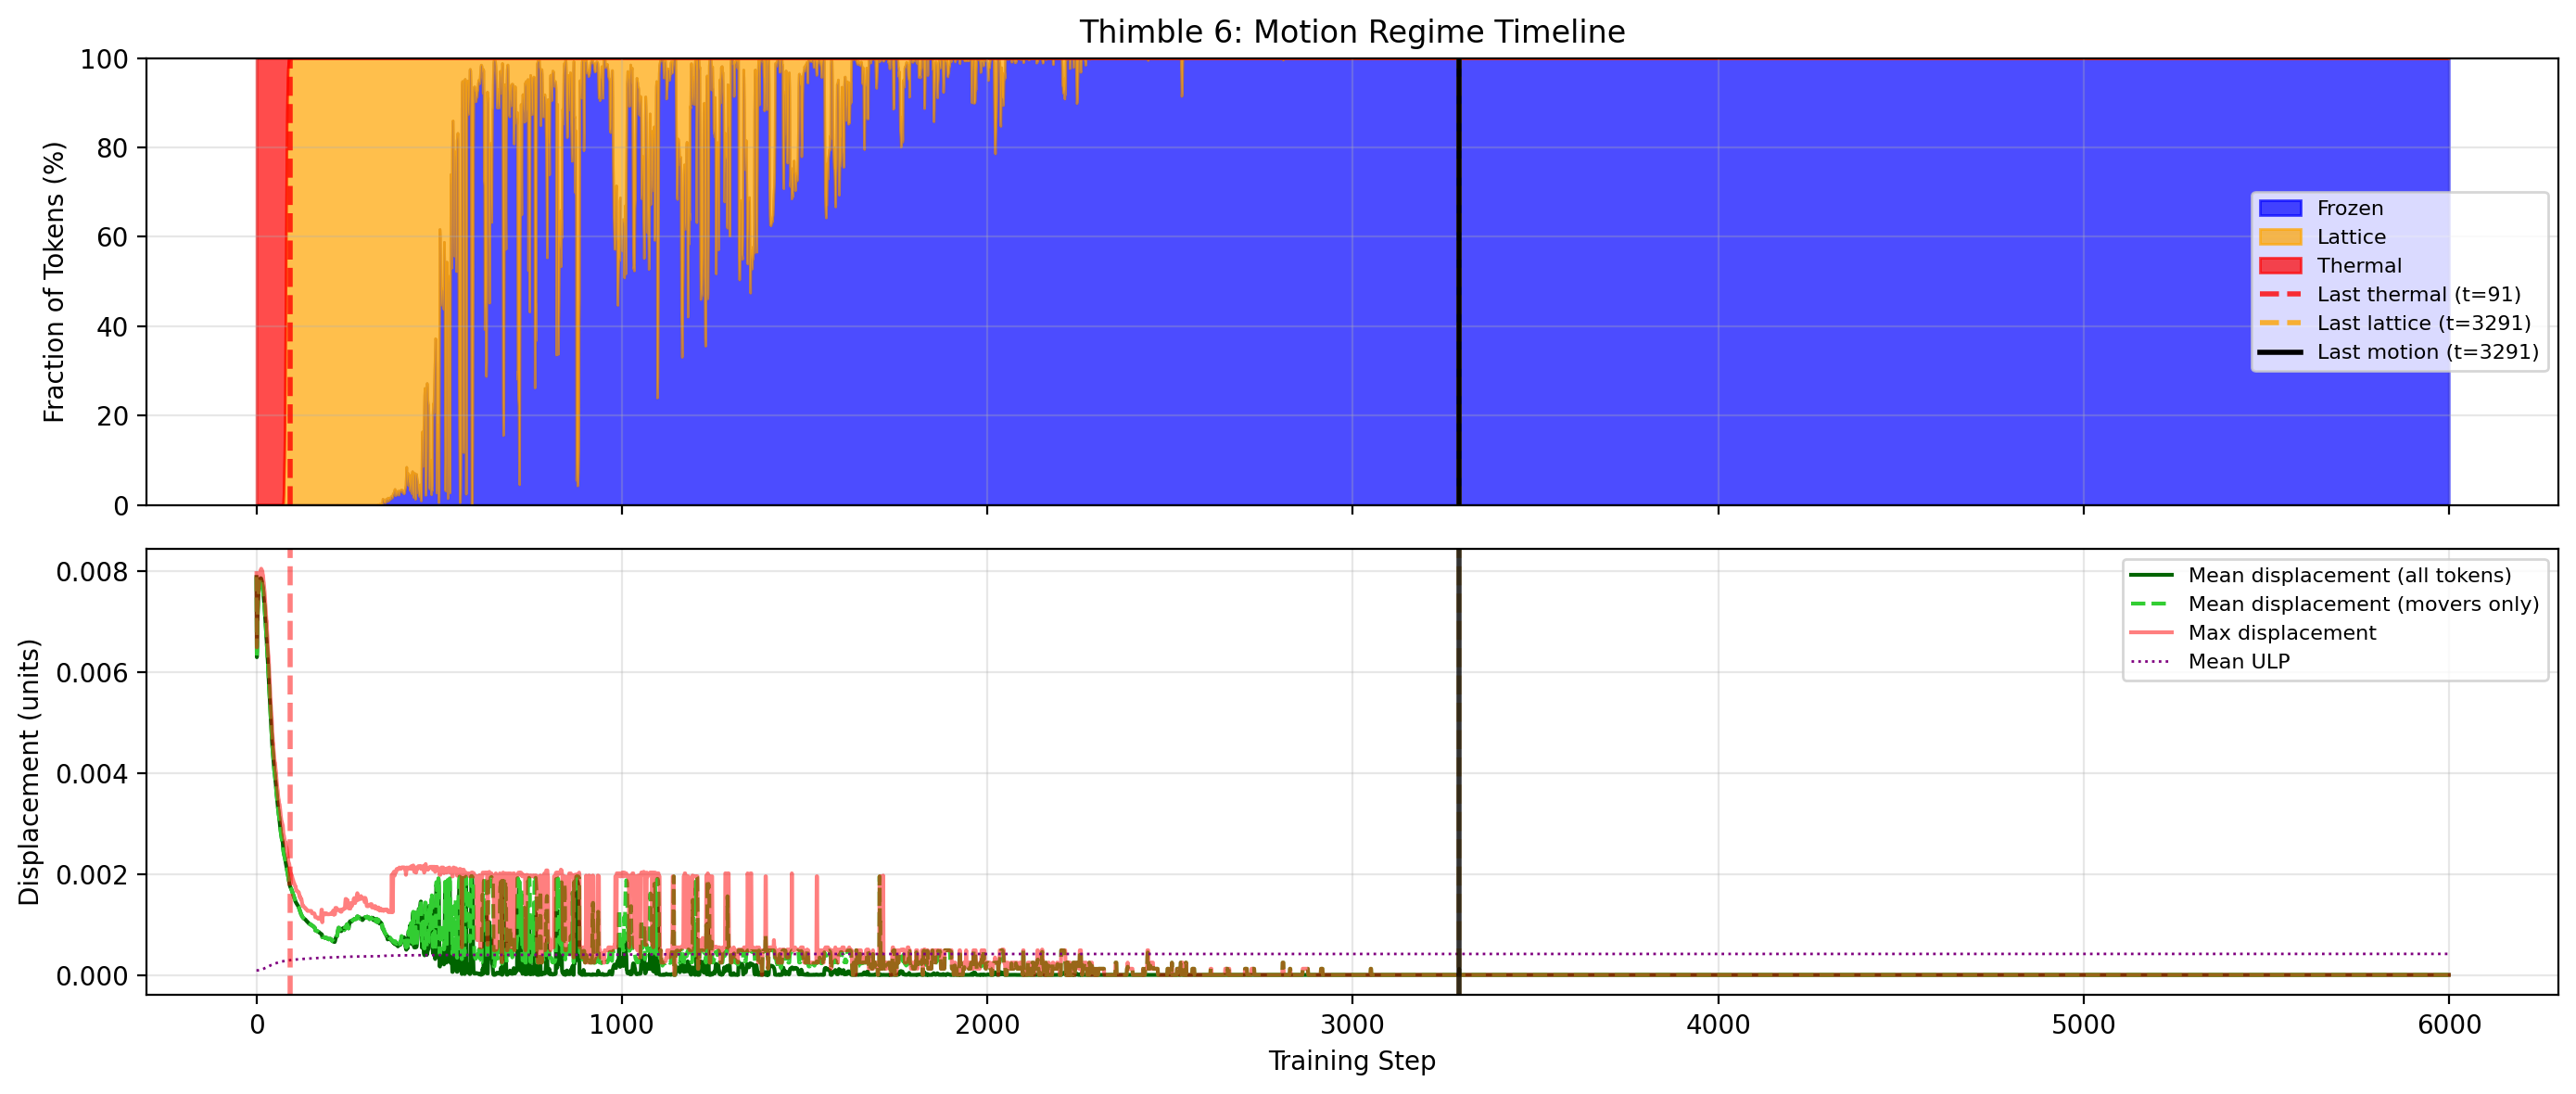

In [18]:
fig, axes = plt.subplots(2, 1, figsize=FIGSIZE, dpi=DPI, sharex=True)

# Top panel: Fraction in each regime
ax = axes[0]
ax.fill_between(range(len(fraction_frozen)), 0, fraction_frozen.numpy()*100, 
                color='blue', alpha=0.7, label='Frozen')
ax.fill_between(range(len(fraction_frozen)), fraction_frozen.numpy()*100, 
                (fraction_frozen + fraction_lattice).numpy()*100, 
                color='orange', alpha=0.7, label='Lattice')
ax.fill_between(range(len(fraction_frozen)), (fraction_frozen + fraction_lattice).numpy()*100, 100,
                color='red', alpha=0.7, label='Thermal')

# Mark transition points
if last_thermal is not None:
    ax.axvline(last_thermal, color='red', linestyle='--', linewidth=2, alpha=0.8, label=f'Last thermal (t={last_thermal})')
if last_lattice is not None:
    ax.axvline(last_lattice, color='orange', linestyle='--', linewidth=2, alpha=0.8, label=f'Last lattice (t={last_lattice})')
if last_motion is not None:
    ax.axvline(last_motion, color='black', linestyle='-', linewidth=2, alpha=1.0, label=f'Last motion (t={last_motion})')

ax.set_ylabel('Fraction of Tokens (%)')
ax.set_title('Thimble 6: Motion Regime Timeline')
ax.legend(loc='right', fontsize=8)
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3)

# Bottom panel: Mean displacement (log scale)
ax = axes[1]
ax.plot(mean_displacement_all.numpy(), linewidth=1.5, color='darkgreen', label='Mean displacement (all tokens)')
ax.plot(mean_displacement_movers.numpy(), linewidth=1.5, color='limegreen', linestyle='--', label='Mean displacement (movers only)')
ax.plot(max_displacement.numpy(), linewidth=1.5, color='red', alpha=0.5, label='Max displacement')
ax.plot(mean_ulp_all.numpy(), linewidth=1, color='purple', linestyle=':', label='Mean ULP')

# Mark transitions
if last_thermal is not None:
    ax.axvline(last_thermal, color='red', linestyle='--', linewidth=2, alpha=0.5)
if last_lattice is not None:
    ax.axvline(last_lattice, color='orange', linestyle='--', linewidth=2, alpha=0.5)
if last_motion is not None:
    ax.axvline(last_motion, color='black', linestyle='-', linewidth=2, alpha=0.8)

ax.set_xlabel('Training Step')
ax.set_ylabel('Displacement (units)')
ax.set_yscale('linear')
ax.legend(loc='best', fontsize=8)
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

## Summary Statistics

In [12]:
print("\n" + "="*80)
print("FIMBULWINTER TIMELINE SUMMARY")
print("="*80 + "\n")

print("Phase transitions:")
if last_thermal is not None:
    print(f"  Thermal → Lattice:  t={last_thermal} (last thermal motion)")
if last_lattice is not None:
    print(f"  Lattice → Frozen:   t={last_lattice} (last lattice hop)")
if last_motion is not None:
    print(f"  Frozen (permanent): t={last_motion+1} (first permanent freeze)")
print()

if last_motion is not None:
    freeze_duration = len(global_freeze) - (last_motion + 1)
    freeze_percent = 100 * freeze_duration / len(global_freeze)
    
    print(f"Permanent freeze statistics:")
    print(f"  Duration: {freeze_duration} steps")
    print(f"  Fraction of experiment: {freeze_percent:.1f}%")
    print(f"  Mean displacement during freeze: {mean_displacement_all[last_motion+1:].mean():.2e}")
    print(f"  Max displacement during freeze:  {max_displacement[last_motion+1:].max():.2e}")
    print()

print(f"Global freeze statistics:")
print(f"  Timesteps with ALL tokens frozen: {global_freeze.sum().item()} / {len(global_freeze)}")
print(f"  Timesteps with ANY motion:        {any_motion.sum().item()} / {len(any_motion)}")
print()

# Verdict
if last_motion is not None and freeze_percent > 50:
    print("✓ HEAT DEATH FIMBULWINTER CONFIRMED")
    print(f"  Motion ceased at t={last_motion}, followed by {freeze_duration} steps of absolute stillness.")
    print(f"  This is {freeze_percent:.1f}% of the entire experiment.")
    if n_exact_zero > 0:
        print(f"  Mean displacement = 0.0 exactly for {n_exact_zero} timesteps.")
    print("  System has reached thermodynamic equilibrium at absolute zero.")
elif last_motion is not None:
    print("✓ PERMANENT FREEZE DETECTED (but late in experiment)")
    print(f"  Motion ceased at t={last_motion}.")
    print(f"  System froze in final {freeze_percent:.1f}% of experiment.")
else:
    print("✓ QUANTUM JITTER PERSISTS")
    print(f"  System never fully freezes—persistent low-amplitude motion throughout.")

print("\n" + "="*80)
print("✓ Fimbulwinter timeline analysis complete.")
print("="*80)


FIMBULWINTER TIMELINE SUMMARY

Phase transitions:
  Thermal → Lattice:  t=91 (last thermal motion)
  Lattice → Frozen:   t=3291 (last lattice hop)
  Frozen (permanent): t=3292 (first permanent freeze)

Permanent freeze statistics:
  Duration: 2708 steps
  Fraction of experiment: 45.1%
  Mean displacement during freeze: 0.00e+00
  Max displacement during freeze:  0.00e+00

Global freeze statistics:
  Timesteps with ALL tokens frozen: 3671 / 6000
  Timesteps with ANY motion:        2329 / 6000

✓ PERMANENT FREEZE DETECTED (but late in experiment)
  Motion ceased at t=3291.
  System froze in final 45.1% of experiment.

✓ Fimbulwinter timeline analysis complete.
